# Cachelib YCSB Graph Plot Scripts

In [1]:
import re
from pprint import pprint

def parse_line(line):
    # Pattern to extract the initial date, time, duration, and total operations
    main_pattern = re.compile(r'\*\*\*(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) (\d+) sec: (\d+) operations;')
    
    # Pattern to extract each operation and its metrics
    operation_pattern = re.compile(r'\[(\w+-?\w*): Count=(\d+) Max=([\d.]+) Min=([\d.]+) Avg=([\d.]+) 90=([\d.]+) 99=([\d.]+) 99.9=([\d.]+) 99.99=([\d.]+)\]')
    
    # Match the main pattern
    main_match = main_pattern.search(line)
    
    if main_match:
        date_time = main_match.group(1)
        duration = int(main_match.group(2))
        total_operations = int(main_match.group(3))
        
        result = {
            'date_time': date_time,
            'duration_sec': duration,
            'total_operations': total_operations,
            'operations': {}
        }
        
        # Find all operations
        operations_matches = operation_pattern.findall(line)
        
        for op in operations_matches:
            operation_name = op[0]
            metrics = {
                'count': int(op[1]),
                'max': float(op[2]),
                'min': float(op[3]),
                'avg': float(op[4]),
                '90th_percentile': float(op[5]),
                '99th_percentile': float(op[6]),
                '99.9th_percentile': float(op[7]),
                '99.99th_percentile': float(op[8])
            }
            result['operations'][operation_name] = metrics
            
        return result
    else:
        return None

def parse_log_file(file_name):
  throughput = []
  read_avg_lat = []
  read_p99_lat = []
  with open(file_name, 'r') as f:
    for line in f:
      if line.startswith("Run throughput(ops/sec"):
        tokens = line.split()
        tp = int(float(tokens[-1]))
        throughput.append(tp)
      elif line.startswith("***"):
         result = parse_line(line)
        #  print(result, line)
         if result is not None and "READ" in result["operations"]:
          read_avg_lat.append(result["operations"]["READ"]["avg"])
          read_p99_lat.append(result["operations"]["READ"]["99th_percentile"])

  return throughput, read_avg_lat, read_p99_lat


        

## 1 KB Workload

### Nvme/SATA

tiering [247389.6, 593052.5, 740779.0, 1484891.4, 210800.8] [8.48, 3.22, 2.61, 1.22, 6.2] [65.66, 17.05, 14.24, 4.97, 40.48]
tiering [0. 0. 0. 0. 0.] [0. 0. 0. 0. 0.] [0. 0. 0. 0. 0.]
striping [146621.4, 370552.3333333333, 570770.6, 930087.0, 125301.2] [16.86, 5.54, 4.36, 1.93, 11.5] [173.18, 40.09, 30.46, 13.58, 96.45]
striping [-0.40732593 -0.37517786 -0.22949949 -0.37363298 -0.40559429] [0.98820755 0.72049689 0.67049808 0.58196721 0.85483871] [1.63752665 1.35131965 1.13904494 1.73239437 1.3826581 ]
caching [259405.0, 658198.5, 977658.6, 1894759.8, 220377.8] [8.03, 2.81, 1.88, 0.97, 5.88] [65.06, 18.02, 9.51, 3.77, 38.62]
caching [0.04856874 0.10984862 0.31977094 0.27602584 0.04543152] [-0.05306604 -0.12732919 -0.27969349 -0.20491803 -0.0516129 ] [-0.00913798  0.0568915  -0.33216292 -0.24144869 -0.04594862]
most [337479.2, 759159.0, 1091048.0, 1917237.0, 288705.0] [6.02, 2.55, 1.76, 0.98, 4.51] [44.16, 14.81, 8.49, 3.69, 27.44]
most [0.36416082 0.28008734 0.47283873 0.29116311 0.3695

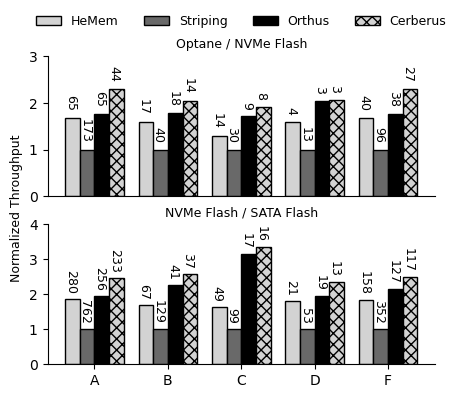

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
result_dir = "result_ver_1"
# latency is in microsecond
hierarchy = ["optane_nvme", "nvme_sata"]
# workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloade", "workloadf"]
workload = ["workloada", "workloadb", "workloadc", "workloadd", "workloadf"] 
mode_list = ["tiering", "striping", "caching", "most"]
color_list = [ 'lightgrey', 'dimgray', 'black', 'lightgray']
label_list = ['HeMem', 'Striping', 'Orthus', 'Cerberus']
hatch_list = ['', '', '', 'xxx']

fig, axes = plt.subplots(2, 1, figsize=(5, 4))

for h_idx, h in enumerate(hierarchy):
  result = {}
  for w in workload:
    base_dir = os.path.join(result_dir, h, w)
    for file_name in os.listdir(base_dir):
      if file_name.endswith('.result'):
        tokens = file_name.split('.')[0].split('_')
        mode = tokens[1]
        tp, read_avg, read_p99 = parse_log_file(os.path.join(base_dir, file_name))
        if mode not in result:
          result[mode] = {}
          result[mode]["tp"] = []
          result[mode]["avg"] = []
          result[mode]["p99"] = []
        
        if w == "workloadd":
          start_idx = -8
          end_idx = -3
        elif w == "workloadb":
          start_idx = -10
          end_idx = -4
        else:
          start_idx = -8
          end_idx = -3
        # print(tp[start_idx:end_idx])

        result[mode]["tp"].append(np.mean(tp[start_idx:end_idx]))
        result[mode]["avg"].append(np.mean(read_avg[int(start_idx/2):end_idx]))
        result[mode]["p99"].append(np.mean(read_p99[int(start_idx/2):end_idx]))

  X = np.array(range(len(workload)))
  width= 0.2
  for idx, mode in enumerate(mode_list):
    print(mode, result[mode]["tp"], result[mode]["avg"], result[mode]["p99"])
    print(mode, (np.array(result[mode]["tp"]) - result["tiering"]["tp"])/ result["tiering"]["tp"], (np.array(result[mode]["avg"]) - result["tiering"]["avg"])/ result["tiering"]["avg"], (np.array(result[mode]["p99"]) - result["tiering"]["p99"])/ result["tiering"]["p99"]) 
    collection = axes[h_idx].bar(X - 3/2 * width + idx *width, np.array(result[mode]["tp"]) /result["striping"]["tp"], width=width, color=color_list[idx], label=label_list[idx], edgecolor='black', hatch=hatch_list[idx])
    for index, bar in enumerate(collection):
      yval = bar.get_height()
      # print(index, )
      
      axes[h_idx].text(bar.get_x() + bar.get_width() * 0.7 / 2, yval+0.15, int(result[mode]["p99"][index]), ha='center', va='bottom', fontsize=9, rotation=-90)
labels = {
  "workloada": "A",
  "workloadb": "B",
  "workloadc": "C",
  "workloadd": "D",
  "workloade": "E",
  "workloadf": "F"
}

axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_title("Optane / NVMe Flash", fontsize=9)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

axes[0].set_ylim(0, 3)
axes[1].set_ylim(0, 4)


axes[0].set_xticks([])
axes[1].set_xticks(X)
axes[1].set_xticklabels([labels[x] for x in workload])
# axes[1].set_xlabel("YCSB Workload")
axes[1].set_title("NVMe Flash / SATA Flash", fontsize=9)

# axes[0].legend(frameon=False, ncol=2)
axes[0].legend(
    frameon=False, fontsize=9, ncol=4, loc="center", bbox_to_anchor=(0.5, 1.25)
)
fig.text(
    0.05,
    0.5,
    "Normalized Throughput",
    va="center",
    rotation="vertical",
    fontsize=9,
)



fig.savefig("ycsb_1k.jpg", dpi=1200, bbox_inches='tight')


